In [1]:
import sys

sys.path.append(r'C:\Users\jerry\Desktop\Research\Kosuri\Rotor_Data_Interpretation\Jerry_Time_to_shine\DORA_Visualization-main\OMMxDORA-main\OMMxDORA-main\sma') #if you are not amanda, change to your sma file path (found in zipfile downloaded from github)


import DORAxCaldera
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import itertools
import seaborn as sns


In [25]:

exp_title = "Exp 9 - 5uM on - Peak "
analysisName='Proflavine_BaseD2ORBIT_Exp9_IB_10hz_20laser_5uM_on_posXY0_channels_t0_posZ0'

# file_name = csvnum   #Jerry Gets rid of old file title
file_name = 'RecBCD_LocPre.csv'

pk = os.path.splitext(file_name)[0]


#universal parameters
exp_tag = exp_title + pk # a tag that caries the name of the experiment


pixel_size = 117  # in nanometers
time_step = 100  # miliseconds per frame in trajectory movie
frame_start = 0  # enter 0 to start from beginning of dataset
frame_end = -1  # enter -1 to end at the last value of the data set
cmap = "spring_r" # enter a color map string from this https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
first_zero_end = 'no'  # yes to cut off all values after first 0,0 = x,y
graph_centers = "no" #'yes' or 'no' to graphing the centers of the data. 
save_plot = 'yes' 

#downsampling parameters
bin_size = 20  # bin size for downsample/filter processing
processing = "none"  # enter downsample, moving average, or none

#Plot Parameters

#Which Graph?
plot_type = "2D_LocPres"
#plot_type = "2D"
#Graphing options:
    #Trajectory Maps:
        #2D: Colorful 2D visulization of the rotor from above
        #3D: 2D plot but time is an axis
        #2D_LocPres: 2D plot now with Localization precision
    
    # Grid plot
        #grid: a grid of little snippets of the data
        
    #Angular Analysis
        #By Jerry
                #radius_filter: Demarcate the erroneous data points that will be eliminated from calculations
                #find_err_angle: Indicate erroneous angles within angular_continuous by Jerry
                #angular_continuous_filtered: Angular Continuous recalculated with erroneous points filtered. Questionable skips indicated.
                #basal3: Graphs tailored for the basal graph analysis 3/14/2022
                    #Angular Continuous with a downsampled curve as well. still has bugs with error labelling



    ############################### these have not been converted yet:
        #By Claire:
                #angular: angle vs time, but it's not cummulative and resets at 360 to 0 (Claire)
                #angular_continuous: Claire's Calculation of a cummulative angle
                #find_err_angle_CR: Indicate erroneous angles within angular_continuous by Claire's calculations

    #Animation
        #interactive: Interactive graph
        #animated: animated trajectory in notebook
        #HTML: Animated trajectory in a new window. May run better

##### Trajectory Maps Parameters:

# "yes" enables center display of center coordinates if 2D or Find err angle
display_center = "no"

#Labels
x_axis_label = "x (nm)"
y_axis_label = "y (nm)"
z_axis_label = "Time (ms)"  
unit = "nm"  # enter pixel or nm

#Formatting parameters
pixel_min = -0.75  # setting min/max axis range (pixel)
pixel_max = 0.75

# change axis increments for nicely fitting tick marks (pixel)
axis_increment_pixel = 7
# change axis increments for nicely fitting tick marks (nm)
axis_increment_nm = 7
nm_min = -150  # setting min/max axis range (nm)
nm_max = 150
#Do you want to save your plot?
save_plot = 'no'

#########Angle Versus Time (AVT or avt) Graphs

#       Formatting parameters for 'radius filter plot'
rad_filter_type_lower = 'nm'  # enter 'zscore' or 'nm' for choice
rad_filter_type_upper = 'zscore'  # enter 'zscore' or 'nm' for choice
z_up = 3  # enter an upper bound for z score.
z_down = -3  # enter a lower bound for z score
dist_low = 30  # lower bound for ABS of Radius filter
dist_high = 70  # upper bound for ABS of Radius filter

#       Formatting parameters for 'angular_continuous_filtered' plot
# enter 'line' or 'scatter' for a line graph or a scatter plot. Line plot makes up points when hovered
graph_style = 'line'


#Formatting parameters 'grid' plot
frames_per_plot = 20  # refers to grid plot
columns = 7  # columns of plots (grid plot)
fig_size_x = 40 # adjust display parameters for graphs to fit nicely, mostly used for 'grid' plot
fig_size_y  = 40 # adjust display parameters for graphs to fit nicely, mostly used for 'grid' plot

#Formatting parameters 'animation' plot
frame_speed = 20  # for animation only (ms)
tail_length = 50  # for animation only

#DORA.table parameters: 
save_table = 'no' #saves filtered table if "yes"

#DORA.collect_variable parameter package
###DataTable = avt_good cannot have bc it has not been defined yet
col = "Delta Angle"
sample_conditions= analysisName
name_saving_folder = "Data Tables"

In [26]:
def find_center(*relevant_parameters):

    # unpackage our list of variables with their associated variables with variable names
    # unpack list into variables
    file_name, time_step, frame_start, frame_end, cmap, exp_tag, first_zero_end, graph_centers,save_plot = relevant_parameters

    # I will analyze the raw data from Ryan's code as pre_data and then covert that into two separate parts
    # 1) (data) the data formatted as arrays to be graphed [necessary numbers only]
    # 2) (data_back) the data formated as a Dataframe for record keeping [NaN placed where erroneous value lies]
    # read the csv file intended
    pre_data = pd.read_csv(file_name, header=None)
    # pre_data = pre_data.dropna()  # drop all NaN values?
    # create an array increasing in steps of
    pre_data['index'] = range(len(pre_data))
    pre_data.columns = ['X position',
                        'Y position', 'Localization Precision','index']  # label the columns
    pre_data = pre_data.iloc[:, [3, 0, 1 ,2]]  # reorganize the columns
    # create a boolean array of where 1s are when x position is 0 or invalid

    #section data from frame start to frame end
    pre_data = pre_data.iloc[frame_start:frame_end]

    # this is bc Ryan's code exports invalid readings as (0,0)
    ind_invalid_reading = pre_data['X position'] == 0

    if first_zero_end == 'yes':
        # run a boolean through the data set to find 0,0 points
        find_first_0 = (pre_data["X position"] == 0) & (
            pre_data["Y position"] == 0)
        # make an array can pre_x that holds all the x positions
        pre_x = pre_data["X position"].copy()
        # run the boolean through the pre_x variable, all 0,0 are true and stay.
        pre_x = pre_data[find_first_0]
        # the first 0,0 is the first item in this new pre_x
        my_first_0 = pre_x.index[0]
        frame_end = my_first_0  # set the index of the first 0,0 point as the end frame

    # SEPARATE data into front and back end (front==graphing ; back == tables)
    # if the index is not invalid (or valid) keep it and store in data
    data = pre_data[~ind_invalid_reading].copy()
    # section the pre data for all the invalid values
    data_back = pre_data[ind_invalid_reading].copy()

    # in data back develop a time colomn
    data_back['Time (ms)'] = data_back['index']*time_step

    # set all target x positions to NaN, if the reading was erroneous
    data_back['X position'] = np.nan
    # set all target y positions to NaN, if the reading was erroneous
    data_back['Y position'] = np.nan
    data_back['Error Type'] = 'Invalid Reading'

    ####################################### CENTERING ALGORITHM ###############################################

    # establish empty lists
    stand = []

    # find uniform guesses in range of max and min unaltered data values for y position
    # THE NUMBER OF UNIFORM GUESSES IS CURRENTLY HARD CODED AT 50 FOR X AND Y, CULMULITIVE 2,500
    guess_y = np.linspace(data.iloc[:, 2].max(
    ), data.iloc[:, 2].min(), 50)
    # put into list
    guess_y = guess_y.tolist()
    # find guesses for x position
    guess_x = np.linspace(data.iloc[:, 1].max(
    ), data.iloc[:, 1].min(), 50)
    guess_x = guess_x.tolist()

    # permute each x and y center guess together to create 10,000 unique center guesses
    center_guesses = list(itertools.product(guess_x, guess_y))
    # store center guesses in dataframe
    c = pd.DataFrame(center_guesses, columns=['X', 'Y'])
    # set up list to store average distances (radius) of circular trajectory path
    ave_distance = []
    # set up list to store standard deviation of distances to each point in the trajectory
    stand = []
    j = 0
    for j in range(len(c)):  # chnage to range(len(c))
        # find the distance between each point in a dataframe against guess[i]
        distance = np.power(
            ((data["X position"] - c['X'][j])**2 + (data["Y position"] - c['Y'][j])**2), 0.5)
        # store distances in a dataframe
        d = pd.DataFrame(distance, columns=['distance'])
        # find average of distances (this would be the radius)
        ave_d = d['distance'].mean(axis=0)
        # store all average distances from each guess[i] distance dataframes into list
        ave_distance.append(ave_d)
        # find standard deviation of center distance from each point in trajectory for each guess[i]
        std = d['distance'].std(axis=0)
        # store each standard deviation in a list
        stand.append(std)

        j += 1
    # put radius and std lists in a dataframe
    c['average_distance'] = ave_distance
    c['std'] = stand

    # this block finds the row with the lowest std, the corresponding radius and x,y coordinates for the center
    # want to return row with lowest std
    target_row = c['std'].idxmin()

    # x center guess with lowest std
    center_x = c.loc[target_row, 'X']
    # y center guess with lowest std
    center_y = c.loc[target_row, 'Y']
    # radius of trajectory
    dist = c.loc[target_row, 'average_distance']
    #Define dist as the estimated radius 
    my_rad_estimate = dist

    ###########GRAPHING BLOCK

    if graph_centers == "yes":

        # Our regularly scheduled 2D graphing program
        fig = plt.figure(figsize=(6, 6), dpi=100)
        # 121 # 1X1 grid plot 1, subplot(222) would be 2X2 grid plot 2, (223)--> 2X2 plot 3
        ax = fig.add_subplot(111)

        # Set up for color bar
        #HARD CODE:
        z_axis_label = "Frames" 

        #collect x and y values
        x =  data.iloc[:, 1] 
        y = data.iloc[:, 2]

        # A color bar associated with time needs two things c and cmap
        #these arguments go into ax.scatter as args

        # c (A scalar or sequence of n numbers to be mapped to colors using cmap and norm.)
        c = data["index"]

        #Make a ticks vector that spans the total number of frames
        # There is a bug because linspace doesn't understand what -1 is but the sequence does
        if frame_end == -1:   # negative 1
            last_frame = pre_data.iloc[:,0].iat[-1] #in the index column, give me the last valid value --> this is the max Frames
        else:
            last_frame = frame_end
        tix = np.linspace(frame_start,last_frame,8)
        tix_1 = np.round(tix,0)


        #scatter plot with a color vector
        p = ax.scatter(x, y, c=c, cmap = cmap,alpha=0.7)
        #add a vertical side bar that defines the color
        plt.colorbar(p, label=z_axis_label, shrink=.82, ticks = tix_1 )


        plt.axis('square')
        plt.xticks(rotation=45)

        # add a red dot to indicate center of trajectory
        ax.scatter(center_x, center_y, color='red')
        plt.text(x=center_x + 0.02, y=center_y + 0.02, s='algorithm centering')

        # add a red dot to indicate center of trajectory
        ax.scatter(center_x, center_y, color='red')
        plt.text(x=center_x + 0.02, y=center_y + 0.02, s='algorithm centering')

        # add a circle with center at our best guess and radius derived from our best guess
        circle = plt.Circle((center_x, center_y), dist, color='r', fill=False)
        ax.add_patch(circle)

        # Colorbar parameters below if we want one in the future

        # cbar = plt.colorbar(p, label= 'time' ,                asdfshrink= .82) #

        # #setting the ticks on the colorbar to span the length of the time column with 6 increments
        # cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # tix = np.linspace(0,len(data),6, dtype = int) # forces colorbar to show time in integers
        # tix_c = tix*20
        # cbar.set_ticklabels(tix_c)

        plt.axis('square')  # INTEGRAL to maintaining aspect ratio
        plt.xticks(rotation=45)
        ax.set_xlabel('X position (unaltered)', fontweight='bold', fontsize=14)
        ax.set_ylabel('Y position (unaltered)', fontweight='bold', fontsize=14)

        # plot title and font configurations

        # take the file name and separate from the extension
        # the first value in the tuple is the number
        # the second is .csv 
        # the number 00086.csv is the peak --> so this code takes the peak number
        pk = os.path.splitext(file_name)[0]

        graph_type = 'Algorithm_Center_Guess'

        # change title order!!! 
        list_of_strings = [graph_type, exp_tag]

        #in quotes is the the delimiter between the items in the string
        # by default it is a _ 
        my_title = "_".join(list_of_strings)

        plt.title(my_title, fontweight='bold', fontsize=16)

        if save_plot == "yes":
                # put title input and date time
                plt.savefig(my_title+"_centering.png")

        plt.show()

    # #below is the key to maintaining the value of the center variable once the user satisfaction is achieved
    # global center

    center = (center_x, center_y)

    if graph_centers == "yes":
        print('The center is {0}'.format(center))

        print('If the center is satisfactory, change the find_center_coordinates parameter to no')
        print('If the center is unsatisfactory, adjust the frame_start and frame_end parameters and try again')


    return center, data, ind_invalid_reading, data_back, my_rad_estimate

In [27]:
initial_parameters = [file_name, time_step, frame_start, frame_end, cmap, exp_tag, first_zero_end, graph_centers,save_plot]
center, data, ind_invalid_reading, data_back, my_rad_estimate = find_center(*initial_parameters)

In [28]:
downsample_parameters = [bin_size, processing, data, center, time_step, pixel_size, frame_start, frame_end]
down_sampled_df = DORAxCaldera.downsample(*downsample_parameters)

In [29]:
#Graph Groupings:
# create a list of the acceptable groupings for the trajectory maps
trajectory_map = ["2D", "3D"]

# create a list of the acceptable groupings for the Angle Time grouping
AngleTime = ["radius_filter", "find_err_angle", "angular_continuous_filtered",
                "basal3", "angular", "angular_continuous", "find_err_angle_CR"]

# create a list of the acceptable groupings for the Animations Grouping

animations = ["interactive", "animated", "HTML"]

#Trajectory map parameters:
tajectory_map_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag]

#Angle Versus Time (AVT or avt) parameters:
avt_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag] 

#Animated Parameters
animated_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag, frame_speed, tail_length] 

#Grid Parameters
grid_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag, 
frames_per_plot, columns, fig_size_x, fig_size_y]


# #DORA.graph(plot_type,*relevant_parameters)

# if plot_type == "2D" or plot_type == "3D":
#     DORA.graph(plot_type,*tajectory_map_parameters)
# if plot_type in animations:
#     %matplotlib notebook
#     DORA.graph(plot_type,*animated_parameters)
# if plot_type == "grid":
#     DORA.graph(plot_type, *grid_parameters)
# else:
#     DORA.graph(plot_type,*avt_parameters)

# graph caldera using sea borne 


In [30]:
down_sampled_df

,index,X position,Y position,Localization Precision,X displacement (pixels),Y displacement (pixels),X displacement (nm),Y displacement (nm),Time (ms),Radius (nm),z-score Rad,Angle
0,0,989.52197,150.41046,0.911790,0.273396,-0.131545,31.987275,-15.390729,0,35.497328,-1.194390,25.694609
1,1,989.46265,150.68140,0.193140,0.214076,0.139395,25.046835,16.309251,100,29.888720,-1.799854,326.929830
2,2,989.48285,150.66527,0.751946,0.234276,0.123265,27.410235,14.422041,200,30.972830,-1.682821,332.248660
3,3,989.51483,150.74721,0.887528,0.266256,0.205205,31.151895,24.009021,300,39.330314,-0.780609,322.378264
4,4,989.52441,150.68672,0.803330,0.275836,0.144715,32.272755,16.931691,400,36.444655,-1.092123,332.316542
...,...,...,...,...,...,...,...,...,...,...,...,...
1394,1394,988.95874,150.22664,0.568123,-0.289834,-0.315365,-33.910635,-36.897669,139400,50.113563,0.383471,132.584421
1395,1395,988.92511,150.38559,0.256706,-0.323464,-0.156415,-37.845345,-18.300519,139500,42.037830,-0.488325,154.193417
1396,1396,989.01135,150.25105,0.137230,-0.237224,-0.290955,-27.755265,-34.041699,139600,43.922569,-0.284863,129.191441
1397,1397,989.02032,150.32292,0.309874,-0.228254,-0.219085,-26.705775,-25.632909,139700,37.016813,-1.030357,136.174315


[Text(0.5, 1.0, 'KDE_Exp 9 - 5uM on - Peak RecBCD_LocPre')]

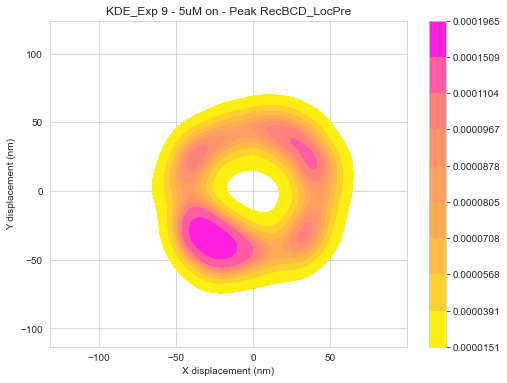

In [39]:
# Claire's code accepts down_sampled_df as df
df = down_sampled_df

#####################Graphing data assignment block##############
# Here the code determines the units of the graph, only for cartesian graphs
if unit == "pixel":
    x = df["X displacement (pixels)"]
    y = df["Y displacement (pixels)"]
if unit == "nm":
    x = df["X displacement (nm)"]
    y = df["Y displacement (nm)"]
z = df["Time (ms)"]
    


# assign values of x y and z
# move this outside this block to apply for all "none"

#Graph KDE uninformed Gausian: 

#Setup Graph Settings

#Define graph size
plt.figure(figsize=(8,6))
#Let there be a Grid
sns.set_style('whitegrid')

# plot title and font configurations
# take the file name and separate from the extension
# the first value in the tuple is the number
# the second is .csv 
# the number 00086.csv is the peak --> so this code takes the peak number
pk = os.path.splitext(file_name)[0]

graph_type = "KDE"

# change title order!!! 
list_of_strings = [graph_type, exp_tag]

#in quotes is the the delimiter between the items in the string
# by default it is a _ 
my_title = "_".join(list_of_strings)


sns.kdeplot( x = x, y = y, n_levels = 10, shade = True, cbar = True, cmap="spring_r",).set(title=my_title)
# sns.rugplot( x = x, y = y)



